# Определение стоимости автомобилей

## Описание задачи

Необходимо построить модель по определению рыночной стоимости автомобиля. Даны исторические данные: технические характеристики, комплектации и цены автомобилей.

Важные параметры модели:

- качество предсказания;
- скорость предсказания;
- время обучения.

Импорт библиотек

In [1]:
!pip install phik -q 
!pip install lightgbm

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import lightgbm
import numpy as np 
import time

In [3]:
from phik.report import plot_correlation_matrix
from phik import phik_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler
    )
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

In [4]:
# константы
TEST_SIZE = 0.25
RANDOM_STATE = 36

## Подготовка данных

In [5]:
df = pd.read_csv('/datasets/autos.csv')

In [6]:
def watch_df(df):
    display(df.info())
    display(df.sample(15))

In [7]:
display(df.loc[df.duplicated(keep=False)]) #проверка полных дубликатов

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [8]:
df = df.drop_duplicates()

In [9]:
watch_df(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
310243,2016-04-01 15:42:40,1000,bus,2000,manual,0,galaxy,150000,6,petrol,ford,NaN,2016-04-01 00:00:00,0,53175,2016-04-07 12:46:30
180316,2016-03-05 19:50:00,13999,wagon,1969,manual,19,500,60000,7,petrol,fiat,no,2016-03-05 00:00:00,0,79291,2016-04-07 14:32:46
6323,2016-03-19 14:46:11,1200,NaN,2017,manual,114,NaN,150000,1,petrol,renault,no,2016-03-19 00:00:00,0,66773,2016-03-30 07:47:22
305464,2016-03-14 19:45:48,4899,sedan,2006,manual,110,corolla,90000,4,petrol,toyota,no,2016-03-14 00:00:00,0,57319,2016-03-28 05:17:27
274617,2016-03-25 13:43:53,3600,wagon,2003,manual,131,mondeo,150000,3,gasoline,ford,no,2016-03-25 00:00:00,0,90765,2016-04-06 15:44:49
285377,2016-04-01 06:37:08,890,bus,2003,manual,116,other,150000,4,petrol,citroen,no,2016-04-01 00:00:00,0,57072,2016-04-07 06:15:41
68179,2016-03-20 10:47:50,250,sedan,1998,auto,101,vectra,150000,2,petrol,opel,NaN,2016-03-20 00:00:00,0,89257,2016-04-06 07:16:51
183121,2016-03-08 09:52:37,1700,NaN,2016,manual,150,golf,150000,0,NaN,volkswagen,yes,2016-03-08 00:00:00,0,23568,2016-04-06 20:19:28
58087,2016-03-05 23:47:38,20000,sedan,2012,auto,143,1er,60000,6,gasoline,bmw,no,2016-03-05 00:00:00,0,49808,2016-04-07 13:16:01
84910,2016-03-28 15:45:43,1999,sedan,1989,manual,116,golf,125000,3,petrol,volkswagen,no,2016-03-28 00:00:00,0,41539,2016-04-01 00:15:21


Удаляю столбцы, не нужные для определения стоимости: DateCrawled, DateCreated, PostalCode, LastSeen, NumberOfPictures, RegistrationMonth

In [10]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])
print(df['DateCrawled'].max())

print(df.info())

2016-04-07 14:36:58
<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        316875 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            334532 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              334660 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           321470 non-null  object        
 10  Brand              354365 non-null  object        
 11  Repaired           283211 non-null  object        
 12  DateCreated        354365 non-null  object        
 13  NumberOfPictures   35436

In [11]:
future_cars = df.loc[(df['RegistrationYear'] >= 2016) & (df['RegistrationMonth'] > 5)].index # автомобили из будущего

df.drop(index = future_cars, inplace = True)

In [12]:
data = df.drop(
    [
        'DateCrawled', 
        'DateCreated', 
        'PostalCode', 
        'LastSeen', 
        'NumberOfPictures',
        'RegistrationMonth'
    ], 
    axis = 1
)
watch_df(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 344286 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             344286 non-null  int64 
 1   VehicleType       316857 non-null  object
 2   RegistrationYear  344286 non-null  int64 
 3   Gearbox           325317 non-null  object
 4   Power             344286 non-null  int64 
 5   Model             325824 non-null  object
 6   Kilometer         344286 non-null  int64 
 7   FuelType          315402 non-null  object
 8   Brand             344286 non-null  object
 9   Repaired          277130 non-null  object
dtypes: int64(4), object(6)
memory usage: 28.9+ MB


None

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
207018,1700,wagon,1998,manual,110,a4,150000,gasoline,audi,no
18017,16900,convertible,1980,manual,63,NaN,100000,petrol,sonstige_autos,no
106704,1999,convertible,2002,auto,54,fortwo,125000,petrol,smart,no
224816,3499,wagon,2004,manual,101,a4,150000,NaN,audi,NaN
15716,3100,wagon,2002,manual,116,3er,150000,gasoline,bmw,yes
126226,735,small,2000,manual,54,corsa,150000,petrol,opel,no
5354,1400,sedan,1993,manual,116,80,150000,petrol,audi,no
44604,4250,wagon,2003,auto,220,a4,150000,petrol,audi,no
332392,850,small,2001,manual,0,corsa,150000,petrol,opel,no
9303,6900,coupe,2001,manual,231,3er,150000,petrol,bmw,no


In [13]:
data.isna().sum()

Price                   0
VehicleType         27429
RegistrationYear        0
Gearbox             18969
Power                   0
Model               18462
Kilometer               0
FuelType            28884
Brand                   0
Repaired            67156
dtype: int64

### Вывод:

В датасете существует несколько аномалий:
1) пропуски столбца VehicleType - можно заполнить модальным значением в зависимости от Model,

2) пропуски столбца Gearbox - восстановить значения невозможно, строки с пропусками лучше удалить,

3) пропуски столбца Model - восстановить значения невозможно, строки с пропусками лучше удалить,

4) пропуски столбца FuelType - восстановить значения невозможно, строки с пропусками лучше удалить,

5) пропуски столбца Repaired - пустые значения можно принять за 'no',

6) значения '0' в столбце Power - можно заполнить модальным значением. 

In [14]:
data['Gearbox'].fillna('unknown', inplace = True)
data['Model'].fillna('unknown', inplace = True)
data['FuelType'].fillna('unknown', inplace = True)

In [15]:
data.Repaired.value_counts() 
# подавляющее большинство машин не было в ремонте. Поэтому могу заполнить пропуски значением no

data.Repaired.fillna('no', inplace = True)

In [16]:
num_features = ['RegistrationYear', 'Price', 'Power', 'Kilometer']
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [17]:
# проверка на наличие неявных дубликатов
for column in cat_features:
    print(column, data[column].unique())

VehicleType [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Gearbox ['manual' 'auto' 'unknown']
Model ['golf' 'unknown' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max'
 '3_reihe' 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco'
 '5er' 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' 'clio' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'megane' 'lupo' 'r19' 'caddy' 'mondeo' 'cordoba' 'colt' 'impreza'
 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'sharan' '6_reihe' 'panda' 'up'
 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'zafira' 'mii' 'rx_reihe'
 '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg' 'logan'
 'spider' 'cuore' 's_ma

Обнаружен неявный дубликат rangerover и range_rover. Произвожу замену rangerover на range_rover

In [18]:
data['Model'] = data['Model'].replace('rangerover', 'range_rover')

## Анализ данных

Провожу анализ категориальных признаков

In [19]:
# задаю размеры будущих графиков
sns.set(rc={'figure.figsize':(8,6)})

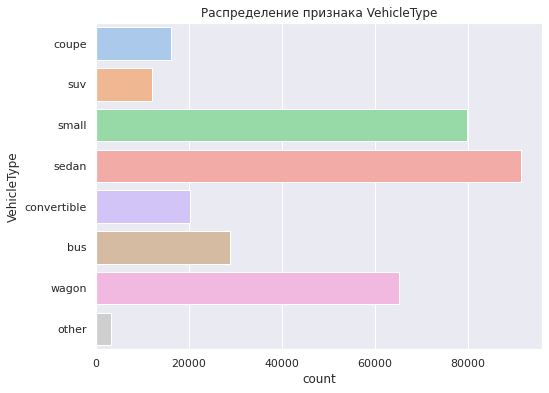

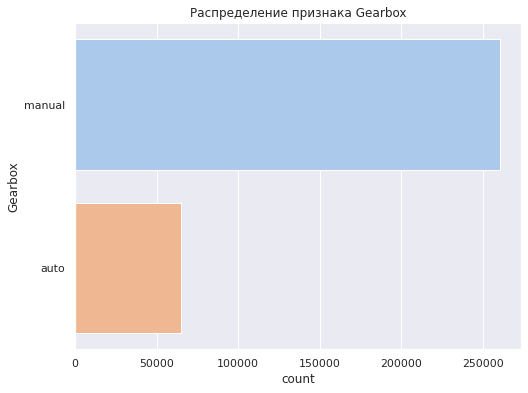

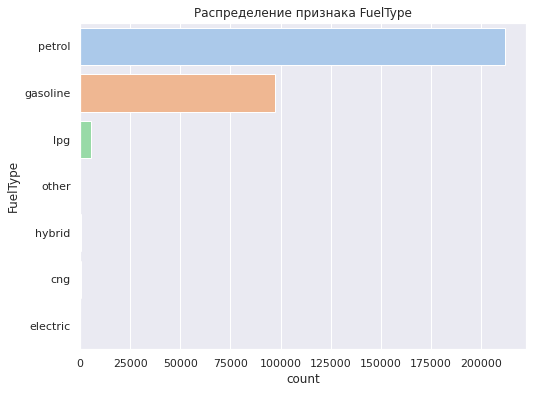

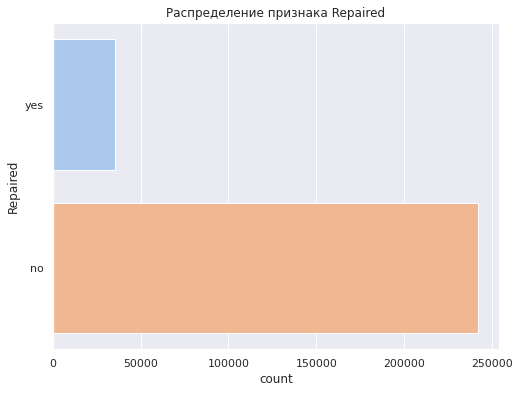

In [20]:
for cat_feature in ['VehicleType', 'Gearbox', 'FuelType', 'Repaired']:
    sns.countplot(
        data = df,
        y = cat_feature,
        palette = 'pastel',  
        ).set_title(f'Распределение признака {cat_feature}')
    
    plt.show()

Так как в датасете большое количество брендов и моделей авто, их исследование при помощи столбцовых диаграмм не будет информативным.

In [21]:
#Перед анализом признака RegistrationYear привожу его к нормальным границам
data = data.loc[(data['RegistrationYear'] > 1900) & (data['RegistrationYear'] < 2024)]

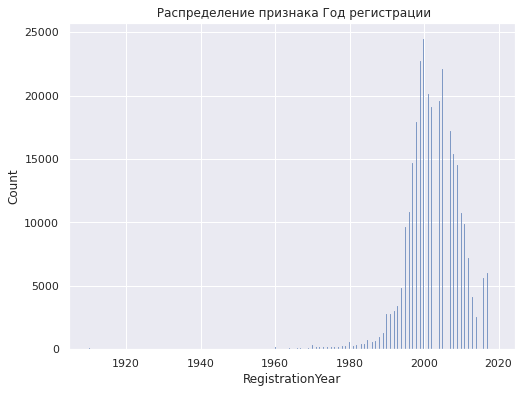

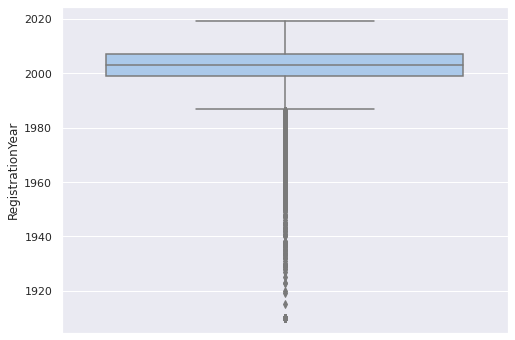

In [22]:
sns.histplot(
        data = data['RegistrationYear'],
        palette = 'pastel'
        ).set_title(f' Распределение признака Год регистрации')
    
plt.show()
    
sns.boxplot(
        data = data,
        palette = 'pastel',
        y = data['RegistrationYear']
        )
    
plt.show()

Все ретро-автомобили являются выбросами. Однако, от аномалий, связанных с некорректным вводом года избавились. 

Наиболее редко выстречаются авто старше 1920 года, поэтому убираю их из итогового датасета

In [23]:
data = data.loc[data['RegistrationYear'] > 1920]

Проверка распределения целевого признака.

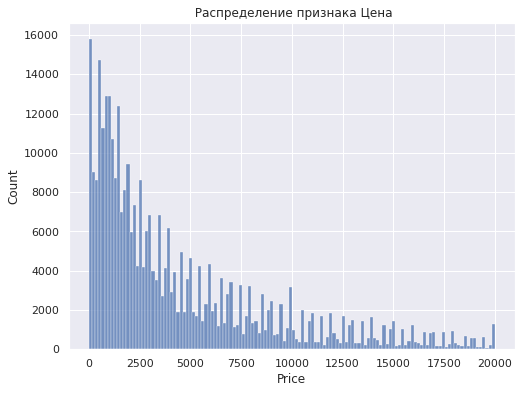

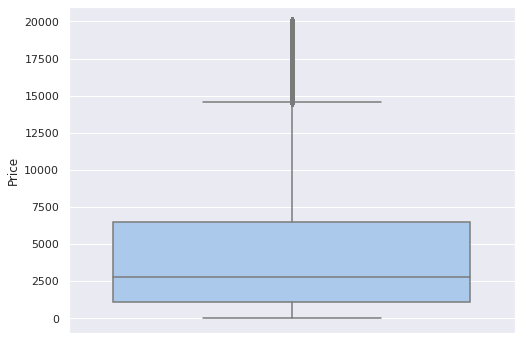

In [24]:
sns.histplot(
        data = data['Price'],
        palette = 'pastel'
        ).set_title(f' Распределение признака Цена')
    
plt.show()
    
sns.boxplot(
        data = data,
        palette = 'pastel',
        y = data['Price']
        )
    
plt.show()

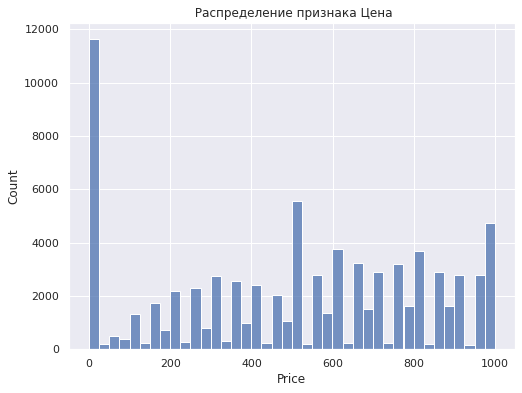

In [25]:
sns.histplot(
        data = (data.loc[data['Price'] < 1000, 'Price']),
        palette = 'pastel'
        ).set_title(f' Распределение признака Цена')
    
plt.show()

Значения, равные 0, однозначно являются аномалиями, которые следует удалить. 

In [26]:
data = data.loc[data['Price'] > 0]

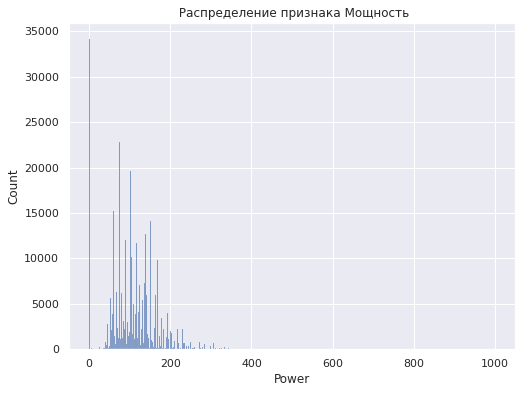

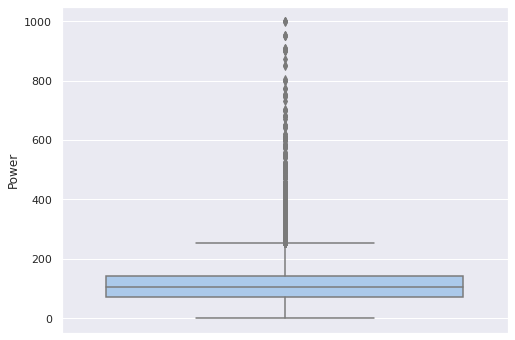

In [27]:
# проверка признака Power
# сначала удаляю аномалии значения Power, которые выше 1000 л.с
data = data.loc[data['Power'] < 1000]
sns.histplot(
        data = data['Power'],
        palette = 'pastel'
        ).set_title(f' Распределение признака Мощность')
    
plt.show()
    
sns.boxplot(
        data = data,
        palette = 'pastel',
        y = data['Power']
        )
    
plt.show()

Чтобы проверить реалистичность указанных данных, проверим объявления с мощностью авто более 500. Данные по автомобилям с мощностью 0 можно заполнить медианными значениями по моделям.

In [28]:
high_power_auto = data.loc[data['Power'] > 500]
display(high_power_auto.sample(20))
print(high_power_auto['Brand'].value_counts())

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
301843,230,small,1993,manual,998,micra,150000,petrol,nissan,no
73749,18500,sedan,2012,auto,520,other,50000,petrol,audi,yes
32693,16999,sedan,2006,auto,515,a8,150000,petrol,audi,no
96747,13500,NaN,2006,auto,521,cayenne,150000,petrol,porsche,yes
212083,4900,other,1999,manual,650,unknown,150000,petrol,sonstige_autos,no
75230,17999,sedan,2012,auto,560,m_reihe,40000,petrol,bmw,no
43556,2850,sedan,2005,manual,900,c4,100000,gasoline,citroen,no
208144,19999,coupe,2007,auto,514,other,150000,petrol,mercedes_benz,no
107164,250,small,2001,manual,580,twingo,150000,petrol,renault,no
14555,599,NaN,2018,manual,599,twingo,150000,unknown,renault,no


audi              18
mercedes_benz     17
bmw               13
volkswagen        11
opel               8
porsche            6
citroen            6
ford               6
renault            6
chevrolet          5
fiat               5
sonstige_autos     4
seat               3
jaguar             3
lancia             2
peugeot            2
nissan             2
smart              2
honda              2
skoda              1
mitsubishi         1
suzuki             1
hyundai            1
toyota             1
Name: Brand, dtype: int64


Присутствует небольшое количество автомобилей, в записи которых присутствует ошибка в мощности. Уберу из датасета совершенно нереалистичные варианты или крайне редко встречающиеся, более 700 лс.

In [29]:
# замена нулевых значений мощности на медианные для модели
for i in data['Model'].unique():
    data.loc[(data['Model'] == i) & (data['Power'] == 0), 'Power'] = \
    data.loc[(data['Model'] == i), 'Power'].median()

In [30]:
data = data.loc[data['Power'] < 700]

Проверка признака Kilometer

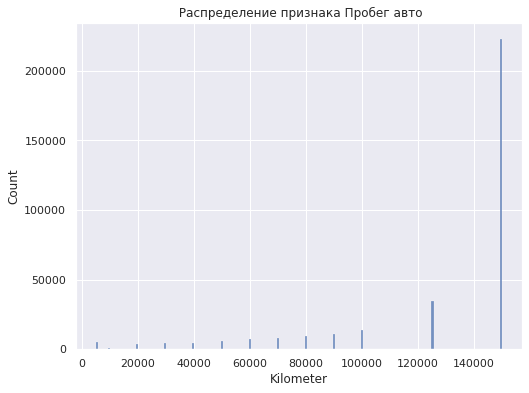

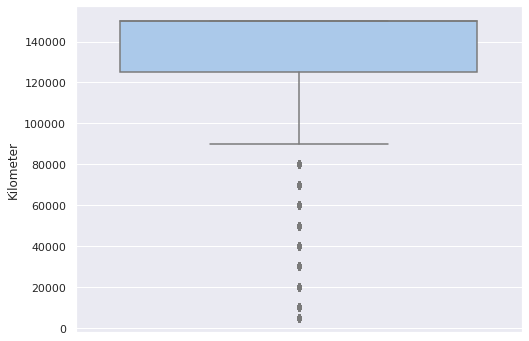

In [31]:
sns.histplot(
        data = data['Kilometer'],
        palette = 'pastel'
        ).set_title(f' Распределение признака Пробег авто')
    
plt.show()
    
sns.boxplot(
        data = data,
        palette = 'pastel',
        y = data['Kilometer']
        )
    
plt.show()

В данном признаке не наблюдается аномалий: большие пробеги являются нормой для объявлений, а низкие являются выбросами. 

In [32]:
watch_df(data)
display(data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333469 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             333469 non-null  int64  
 1   VehicleType       309533 non-null  object 
 2   RegistrationYear  333469 non-null  int64  
 3   Gearbox           333469 non-null  object 
 4   Power             333469 non-null  float64
 5   Model             333469 non-null  object 
 6   Kilometer         333469 non-null  int64  
 7   FuelType          333469 non-null  object 
 8   Brand             333469 non-null  object 
 9   Repaired          333469 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 28.0+ MB


None

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
288153,1700,sedan,1999,manual,179.0,a6,150000,unknown,audi,no
134808,2500,NaN,2005,unknown,75.0,unknown,150000,unknown,audi,no
165839,800,sedan,2002,manual,75.0,golf,150000,petrol,volkswagen,no
222266,2950,sedan,1979,manual,90.0,3er,125000,petrol,bmw,no
336977,5000,wagon,2006,manual,140.0,a4,150000,gasoline,audi,no
95758,8700,wagon,2008,manual,143.0,3er,125000,petrol,bmw,no
3233,19999,suv,2014,auto,163.0,kuga,90000,gasoline,ford,no
203074,2950,bus,2004,manual,140.0,touran,150000,gasoline,volkswagen,yes
247810,2590,small,2004,manual,54.0,polo,125000,petrol,volkswagen,no
23768,1099,NaN,2017,manual,75.0,lanos,125000,unknown,daewoo,no


Price                   0
VehicleType         23936
RegistrationYear        0
Gearbox                 0
Power                   0
Model                   0
Kilometer               0
FuelType                0
Brand                   0
Repaired                0
dtype: int64

In [33]:
#for i in data['Model'].unique():
#    data.loc[(data['Model'] == i) & (data['VehicleType'].isna()), 'VehicleType'] = data.loc[(data['Model'] == i), 'VehicleType'].mode()

# тут возникла проблема с выполнением кода: пропуски не заполнялись медианными значениями, 
# а оставались без изменений. 

# Не нашел другого варианта, как удалить эти строки.
data['VehicleType'].fillna('unknown', inplace = True)

In [34]:
watch_df(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333469 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             333469 non-null  int64  
 1   VehicleType       333469 non-null  object 
 2   RegistrationYear  333469 non-null  int64  
 3   Gearbox           333469 non-null  object 
 4   Power             333469 non-null  float64
 5   Model             333469 non-null  object 
 6   Kilometer         333469 non-null  int64  
 7   FuelType          333469 non-null  object 
 8   Brand             333469 non-null  object 
 9   Repaired          333469 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 28.0+ MB


None

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
328073,4900,small,2012,manual,68.0,unknown,60000,petrol,peugeot,no
224432,10480,sedan,2005,auto,272.0,e_klasse,125000,lpg,mercedes_benz,no
211076,9699,sedan,2011,manual,116.0,astra,50000,petrol,opel,no
3780,6100,wagon,2007,manual,163.0,3er,150000,gasoline,bmw,yes
57044,950,wagon,1999,manual,101.0,focus,5000,petrol,ford,no
260469,600,sedan,1997,manual,90.0,escort,150000,petrol,ford,no
230928,3200,convertible,2008,manual,140.0,astra,125000,petrol,opel,no
23519,2200,sedan,1994,auto,193.0,c_klasse,150000,lpg,mercedes_benz,no
143643,13500,sedan,2011,auto,204.0,c_klasse,150000,gasoline,mercedes_benz,no
278222,2000,small,2005,manual,75.0,golf,150000,petrol,volkswagen,no


### Вывод

Благодаря анализу признаков были выявлены и устранены аномалии: некорректный год регистрации авто, нереалистичная мощность. Также, были удалены объявления с отсутствующими ценами (price = 0). 


После предобработки признаков можно проводить корреляционный анализ. 

## Корреляционный анализ

Для корреляционного анализа выбрал фи-матрицу, учитывающую категориальные, количественные и интервальные признаки

In [35]:
interval_features = [     # записываю интервальные признаки в переменную
    'Power',
    'Price'
    ]

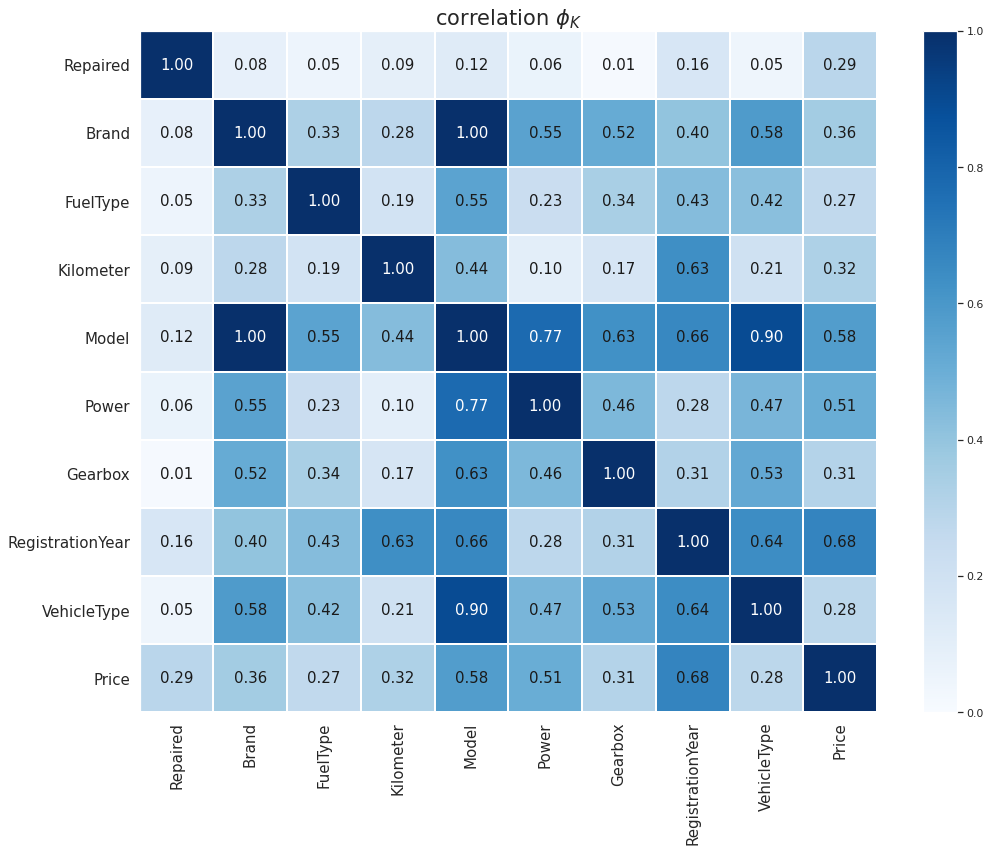

In [36]:
phik_overview = data.phik_matrix(interval_cols=interval_features)

plot_correlation_matrix(
    phik_overview.values, 
    x_labels=phik_overview.columns, 
    y_labels=phik_overview.index, 
    title=r"correlation $\phi_K$", 
    fontsize_factor=1.5,
    vmin=0, vmax=1,
    color_map='Blues',
    figsize=(15, 12)
    )

### Вывод

Матрица корреляции показывает, что у признаков Model и Brand присутствуе мультиколленираность. Таким образом, для устойчивой работы модели удаляю признак Brand. Model оставляю, так как она отражает более узкую и, следовательно, более точную кластеризацию объявлений. 

In [37]:
data = data.drop(['Brand'], axis = 1)

In [38]:
watch_df(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333469 entries, 0 to 354368
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             333469 non-null  int64  
 1   VehicleType       333469 non-null  object 
 2   RegistrationYear  333469 non-null  int64  
 3   Gearbox           333469 non-null  object 
 4   Power             333469 non-null  float64
 5   Model             333469 non-null  object 
 6   Kilometer         333469 non-null  int64  
 7   FuelType          333469 non-null  object 
 8   Repaired          333469 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 25.4+ MB


None

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Repaired
259065,3200,convertible,2004,manual,90.0,tigra,150000,petrol,no
256603,2000,unknown,2005,manual,75.0,golf,150000,unknown,yes
333125,3500,wagon,2009,manual,75.0,logan,100000,petrol,no
123608,2500,small,2002,manual,90.0,one,150000,lpg,yes
231799,8400,sedan,2003,auto,231.0,5er,150000,petrol,no
248338,999,sedan,1998,manual,101.0,passat,150000,petrol,no
289047,5300,sedan,1986,manual,171.0,3er,150000,petrol,no
135234,1300,small,1997,manual,60.0,polo,90000,petrol,no
312187,2500,wagon,2001,manual,140.0,ptcruiser,150000,petrol,no
17759,18500,small,2013,manual,184.0,cooper,30000,petrol,no


Удаляю полные дубликаты строк после удаления признаков, которые не будут использоваться в моделировании

In [39]:
count_1 = len(data)

data = data.drop_duplicates()

count_2 = len(data)
res = count_1 - count_2

print('Удалено строк-дубликатов:', res)

Удалено строк-дубликатов: 51279


## Обучение моделей

In [40]:
# деление на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Price'], axis = 1),
    data['Price'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE
    )

In [42]:
num_columns = ['RegistrationYear', 'Power', 'Kilometer']
cat_columns = ['VehicleType', 'Gearbox', 'FuelType', 'Model', 'Repaired']

In [43]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values='unknown', strategy='most_frequent')
        ),
        (
            'ohe', OneHotEncoder(handle_unknown='ignore', sparse=False)
        )
    ]
)


data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline(
    [
        (
            'preprocessor', data_preprocessor
        ),
        (
            'models', DecisionTreeRegressor(random_state=RANDOM_STATE)
        )
    ]
)

In [44]:
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(missing_values='unknown',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'FuelType', 'Model',
                                                   'Repaired']),
                                                 ('nu

In [45]:
param_grid_1 = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

In [46]:
grid_search_1 = GridSearchCV(
    pipe_final, 
    param_grid_1, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
    )

In [47]:
start = time.time()
grid_search_1.fit(X_train, y_train)

finish = time.time()
res = finish - start
print('Время выполнения кода - ', res)

Время выполнения кода -  211.99218606948853


In [48]:
print('Метрика модели LinearRegression при кросс-валидации:', ((grid_search_1.best_score_)*-1))
print('Время обучения модели LinearRegression', ((grid_search_1.refit_time_)))

Метрика модели LinearRegression при кросс-валидации: 68657.80727296673
Время обучения модели LinearRegression 12.302168369293213


In [49]:
ord_pipe = Pipeline(
    [
        ('simpleImputer_ord_one', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('simpleImputer_ord_two', SimpleImputer(missing_values=' ', strategy='most_frequent')),
        ('ord', OrdinalEncoder(
                categories=[
                    data['VehicleType'].unique(),
                    data['Gearbox'].unique(),
                    data['FuelType'].unique(),
                    data['Model'].unique(),
                    data['Repaired'].unique()
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
                ))
    ]
)

data_preprocessor_2 = ColumnTransformer(
    [
        ('ord', ord_pipe, cat_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final_2 = Pipeline(
    [
        (
            'preprocessor', data_preprocessor_2
        ),
        (
            'models', DecisionTreeRegressor(random_state=RANDOM_STATE)
        )
    ]
)

In [50]:
pipe_final_2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_ord_one',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ord_two',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[array(['unknown', 'coupe', 'suv', 'small', 'sedan', 'convert...
       'range_rover_evoque', 'materia', 'delta', 'gl', 'kalina',
       'elefantino', 'i3', 'amarok', 'kappa', 'ser

In [51]:
param_grid_2 = [
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

In [52]:
grid_search_2 = GridSearchCV(
    pipe_final_2, 
    param_grid_2, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
    )

In [53]:
start = time.time()
grid_search_2.fit(X_train, y_train)

finish = time.time()
res = finish - start
print('Время выполнения кода - ', res)

Время выполнения кода -  105.69170069694519


In [54]:
print('Метрика модели LGBMRegressor при кросс-валидации:', ((grid_search_2.best_score_)*-1))
print('Время обучения модели LGBMRegressor', ((grid_search_2.refit_time_)))

Метрика модели LGBMRegressor при кросс-валидации: 1855.7021426371084
Время обучения модели LGBMRegressor 5.602081298828125


In [55]:
param_grid_3 = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(7,10),
        'models__min_samples_leaf': range(4,6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
    }
]

In [56]:
grid_search_3 = GridSearchCV(
    pipe_final_2, 
    param_grid_3, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
    )

In [57]:
start = time.time()
grid_search_3.fit(X_train, y_train)

finish = time.time()
res = finish - start
print('Время выполнения кода - ', res)

Время выполнения кода -  72.91792559623718


In [58]:
print('Метрика модели DecisionTreeRegressor при кросс-валидации:', ((grid_search_3.best_score_)*-1))
print('Время обучения модели DecisionTreeRegressor', ((grid_search_3.refit_time_)))

Метрика модели DecisionTreeRegressor при кросс-валидации: 2183.517972594406
Время обучения модели DecisionTreeRegressor 0.699094295501709


### Вывод

Лучшую метрику rmse при кросс-валидации показала модель LGBMRegressor (~1855). Скорость обучения на втором месте среди моделей: 5.1 секунды. 


Второе место среди моделей заняла модель DecisionTreeRegressor с метрикой при кросс-валидации (~ 2183.52), при этом время обучения модели наименьшее из трех - 0,75 секунды. 


Третье место среди моделей принадлежит LinearRegression. Метрика rmse при кросс-валидации крайне высока, поэтому модель нежизнеспособна. 

## Анализ моделей

### Измерение скорости предсказаний

In [59]:
# Получение предсказаний первой модели - LinearRegression
start = time.time()

grid_search_1.predict(X_test)

finish = time.time()
res_lin = finish - start
print('Время предсказания LinearRegression - ', res_lin)


# Получение предсказаний второй модели - LGBM
start = time.time()

grid_search_2.predict(X_test)

finish = time.time()
res_lgbm = finish - start
print('Время предсказания LGBM - ', res_lgbm)

# Получение предсказаний второй модели - DecisionTreeRegressor
start = time.time()

grid_search_3.predict(X_test)

finish = time.time()
res_tree = finish - start
print('Время предсказания DecisionTreeRegressor - ', res_tree)

Время предсказания LinearRegression -  0.29213809967041016
Время предсказания LGBM -  0.6855413913726807
Время предсказания DecisionTreeRegressor -  0.1889786720275879


### Вывод

При получении предсказаний модели лучшую скорость показала LinearRegression, второе место у DecisionTreeRegressor, третье место - LGBM

### Проверка  лучшей модели на тестовых данных

In [60]:
preds_lgbm = grid_search_2.predict(X_test)
score = mean_squared_error(y_test, preds_lgbm, squared=False)
print('Метрика RMSE модели LGBM на тестовых данных: ', score)

# preds_tree = grid_search_3.predict(X_test)
# score = mean_squared_error(y_test, preds_tree, squared=False)
# print('Метрика RMSE модели DecisionTreeRegressor на тестовых данных: ', score)

# Переобучение отсутствует в обоих моделях

Метрика RMSE модели LGBM на тестовых данных:  1863.8595358695597


Переобучение модели отсутствует, LGBM показывает отличный результат как на кросс-валидации, так и на тестовых данных. 

# Общий вывод

В процессе работы над датасетом был проведен анализ и предобработка данных. Были удалены полные дубликаты строк, устранены неявные дубликаты.


После проведения анализа данных были удалены или скорректированы значения числовых признаков: исправлены значения года регистрации автомобиля, мощности, цены. Отсутствующие значения были заменены заглушкой unknown.  


На основе датасета были обучены 3 модели: линейная регрессия, регрессия дерева решений и модель градиентного бустинга LightGBM. Лучшей моделью оказалсь LightGBM, которая обучилась быстрее всего и показала наивысшую точность по RMSE. 

Также была замерена скорость получения предсказаний модели. Самое большое время обучения у модели LGBM, однако, речь идет о полутора секундах против половины секунды для модели, занимающей второе место по скорости предсказания, точность которой заметно ниже. 

Итог: для получения предсказания цены автомобиля рекомендую использовать модель LGBM.